In [ ]:
# Notebook: Hugging Face Semantic Search via Sentence Similarity
# Author: Thomas Purk
# Date: 2025-04-05
# Reference: https://huggingface.co/datasets/lewtun/github-issues
# Reference: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
# Reference: https://sbert.net/
# Reference: https://github.com/facebookresearch/faiss
# Reference: https://pypi.org/project/faiss-gpu-cu12/

# Hugging Face Semantic Search via Sentence Similarity

> Sentence Transformers (a.k.a. SBERT) is the go-to Python module for accessing, using, and training state-of-the-art embedding and reranker models. It can be used to compute embeddings using Sentence Transformer models or to calculate similarity scores using Cross-Encoder (a.k.a. reranker) models. This unlocks a wide range of applications, including semantic search, semantic textual similarity, and paraphrase mining.

https://sbert.net/

**Model**

> all-MiniLM-L6-v2 This is a sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

**Dataset**
This data set will serve as the database of text to which we will ask our search query.

> GitHub Issues is a dataset consisting of GitHub issues and pull requests associated with the 🤗 Datasets repository. It is intended for educational purposes and can be used for semantic search or multilabel text classification. The contents of each GitHub issue are in English and concern the domain of datasets for NLP, computer vision, and beyond.

https://huggingface.co/datasets/lewtun/github-issues

**Course Work**

This notebook re-works the lessons from the "Semantic search with FAISS" module of the Hugging Face "NLP Course" (now called "LLM Course").

https://huggingface.co/learn/llm-course/en/chapter5/6?fw=pt

## Notebook Setup

NOTE: 2025-4-5 : Google colab preinstalls CUDA 12.4, which is not compatible with the pre-compiled versions of faiss-gpu. This notebook attempts to roll-back and resolve dependecies by uninstalling and re-installing several packages

In [ ]:
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
!pip list | grep "datasets\|transformers\|sentence_transformers"

datasets                           3.5.0
sentence-transformers              3.4.1
tensorflow-datasets                4.9.8
transformers                       4.50.3
vega-datasets                      0.9.0


In [96]:
# Setup the Notebook

# General
import os
import json
import logging
logging.getLogger("transformers").setLevel(logging.WARNING) # Suppress unnecessary logging

# Visualization
import pprint
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

# Data, Science, & Math
import numpy as np
import pandas as pd

# Machine/Deep Learning
import torch

# NLP
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, util

In [ ]:
if torch.cuda.is_available():
    device_id = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(device_id)
    print(f"GPU Name: {gpu_name}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("CUDA is not available. Running on CPU.")

print(f'PyTorch Version: {torch.__version__}')

GPU Name: Tesla T4
CUDA Version: 12.4
PyTorch Version: 2.6.0+cu124


# Arrange the Data

In [ ]:
# Load the data
ds_git_issues = load_dataset("lewtun/github-issues", split="train")

# Filter out the pull requests
# PRs are rarely used for answering user queries and will introduce noise in the search engine.
# Also filter issue records with not comments
ds_git_issues = ds_git_issues.filter(
    lambda x: (x["is_pull_request"] == False and len(x["comments"]) > 0)
)

# Eliminate columns that will not be used in the search
columns = ds_git_issues.column_names
columns_to_keep = ["title", "body", "html_url", "comments"]
columns_to_remove = set(columns_to_keep).symmetric_difference(columns)
# Remove the columns
ds_git_issues = ds_git_issues.remove_columns(columns_to_remove)

ds_git_issues

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


datasets-issues-with-comments.jsonl:   0%|          | 0.00/12.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3019 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3019 [00:00<?, ? examples/s]

Dataset({
    features: ['html_url', 'title', 'comments', 'body'],
    num_rows: 808
})

In [ ]:
# Show Dataset Info
print(f'Type: {type(ds_git_issues)}')
print('')
print(f'Column Names: {ds_git_issues.column_names}')
print('')
print(f'Total Training Rows: {ds_git_issues.num_rows}')
print(f'Total Test Rows: {ds_git_issues.num_rows}')

Type: <class 'datasets.arrow_dataset.Dataset'>

Column Names: ['html_url', 'title', 'comments', 'body']

Total Training Rows: 808
Total Test Rows: 808


In [ ]:
# Example Record
print(f'Example Record:\n')
ds_git_issues[0]

Example Record:



{'html_url': 'https://github.com/huggingface/datasets/issues/2945',
 'title': 'Protect master branch',
 'comments': ['Cool, I think we can do both :)',
  '@lhoestq now the 2 are implemented.\r\n\r\nPlease note that for the the second protection, finally I have chosen to protect the master branch only from **merge commits** (see update comment above), so no need to disable/re-enable the protection on each release (direct commits, different from merge commits, can be pushed to the remote master branch; and eventually reverted without messing up the repo history).'],
 'body': 'After accidental merge commit (91c55355b634d0dc73350a7ddee1a6776dbbdd69) into `datasets` master branch, all commits present in the feature branch were permanently added to `datasets` master branch history, as e.g.:\r\n- 00cc036fea7c7745cfe722360036ed306796a3f2\r\n- 13ae8c98602bbad8197de3b9b425f4c78f582af1\r\n- ...\r\n\r\nI propose to protect our master branch, so that we avoid we can accidentally make this kind of m

In [ ]:
# Explode the data so that there is a single record for each comment list item

ds_git_issues = ds_git_issues.with_format("python")
df_git_issues = ds_git_issues.to_pandas()

df_git_issues = df_git_issues.explode(
    column="comments",
    ignore_index=True
)
df_git_issues.head(5)

,html_url,title,comments,body
0,https://github.com/huggingface/datasets/issues...,Protect master branch,"Cool, I think we can do both :)",After accidental merge commit (91c55355b634d0d...
1,https://github.com/huggingface/datasets/issues...,Protect master branch,@lhoestq now the 2 are implemented.\r\n\r\nPle...,After accidental merge commit (91c55355b634d0d...
2,https://github.com/huggingface/datasets/issues...,Backwards compatibility broken for cached data...,Hi ! I guess the caching mechanism should have...,## Describe the bug\r\nAfter upgrading to data...
3,https://github.com/huggingface/datasets/issues...,Backwards compatibility broken for cached data...,"If it's easy enough to implement, then yes ple...",## Describe the bug\r\nAfter upgrading to data...
4,https://github.com/huggingface/datasets/issues...,Backwards compatibility broken for cached data...,Well it can cause issue with anyone that updat...,## Describe the bug\r\nAfter upgrading to data...


In [ ]:
# Conversion to pandas supported executing "explode"
# Now covert the exploded dataframe back to a Dataset
# 808 rows are now 2,964 rows

ds_ex_git_issues = Dataset.from_pandas(df_git_issues)
ds_ex_git_issues

Dataset({
    features: ['html_url', 'title', 'comments', 'body'],
    num_rows: 2964
})

In [ ]:
# Create a comments length column
# Filter out records with short comments

# create a new comments_length column that contains the number of words per comment:
ds_ex_git_issues = ds_ex_git_issues.map(
    lambda x: {"comment_length": len(x["comments"].split())}
)

# Educated guess; 15 words seems or more might contain useful comments
ds_ex_git_issues = ds_ex_git_issues.filter(lambda x: x["comment_length"] > 15)


Map:   0%|          | 0/2964 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2964 [00:00<?, ? examples/s]

In [ ]:
# Concatenate title, body and comments
# The new string will be encoded for search
def concatenate_text(examples):
    ''' Combines the text from several features into a new text feature. '''

    return {
        "text": examples["title"]
        + " \n "
        + examples["body"]
        + " \n "
        + examples["comments"]
    }

ds_ex_git_issues = ds_ex_git_issues.map(concatenate_text)

Map:   0%|          | 0/2175 [00:00<?, ? examples/s]

In [ ]:
# Validate new feature
ds_ex_git_issues

Dataset({
    features: ['html_url', 'title', 'comments', 'body', 'comment_length', 'text'],
    num_rows: 2175
})

## Create Text Embeddings

- The encoded text will be used as the search database

In [ ]:
# Identify the model checkpoint
checkpoint = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(checkpoint)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Move the model to the CUDA device
cuda_device = torch.device("cuda")
model.to(cuda_device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [ ]:
# Encode the entire string as a single vector of encoded values
# Encode the corpus into dense vectors
corpus_embeddings = model.encode(ds_ex_git_issues['text'], convert_to_tensor=True)

## Semantic Search

- Ask a question and convert the entire text to a vector embedding
- Find the vectors in the dataset that are nearest the vector of the question

In [95]:
# Ask the question and encode
question = "How can I load a dataset offline?"

# Encode the question into a dense vector
question_embedding = model.encode(question, convert_to_tensor=True)

# Compute cosine similarities
cos_scores = model.similarity(question_embedding, corpus_embeddings)

tensor([[-0.0668,  0.2174,  0.2174,  ...,  0.4365,  0.4365,  0.4365]],
       device='cuda:0')

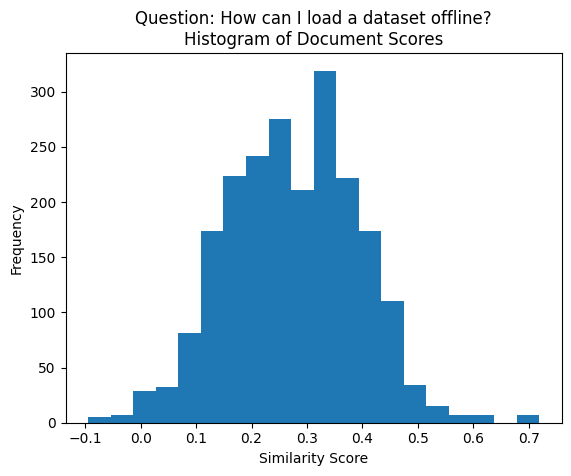

In [145]:
# Create a histogram
hist = torch.histogram(cos_scores.cpu(), bins=20)

bin_counts = hist.hist.cpu().numpy()
bin_edges = hist.bin_edges.cpu().numpy()
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.bar(bin_centers, bin_counts, width=bin_edges[1]-bin_edges[0])
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.title("Question: How can I load a dataset offline?\nHistogram of Document Scores")
plt.show()

In [109]:
# Observation: The number of documents scoring above 0.5 seems small
# What is the number?
filtered_scores = cos_scores[cos_scores > 0.5]

display(filtered_scores)
print('')
display(filtered_scores.size())

tensor([0.5179, 0.5835, 0.5024, 0.5382, 0.5531, 0.5562, 0.5440, 0.5061, 0.5120,
        0.5120, 0.5120, 0.5120, 0.5120, 0.5120, 0.5069, 0.5019, 0.5283, 0.5503,
        0.5657, 0.6072, 0.5118, 0.5711, 0.5703, 0.5667, 0.5154, 0.5154, 0.5626,
        0.5051, 0.5148, 0.7186, 0.7186, 0.7186, 0.7186, 0.7186, 0.7186, 0.6995,
        0.5010, 0.5367, 0.5367, 0.5367, 0.5320, 0.6200, 0.6338, 0.6098, 0.5240,
        0.5370, 0.5980, 0.5342, 0.5984, 0.6252], device='cuda:0')

torch.Size([50])

In [144]:
# Get top-k results
top_results = torch.topk(cos_scores, k=50)


# Because the corups data was exploded based on the comments list
# There could be duplication titles and scores.
# Make a unique list
unique_list = []
ind_size = top_results.indices[0].count_nonzero().item()
for i in range(0,ind_size):
    idx = top_results.indices[0][i].item()
    title = ds_ex_git_issues[idx]['title']
    score = top_results.values[0][i].item()
    l = [title,score ]
    if(l not in unique_list):
        unique_list.append(l)

# Print top-k results
print("\nQuery:", question)
print("\nTop similar sentences in corpus:")
for r in unique_list:
    print(f"(Score: {r[1]:.4f}) {r[0]} ")


Query: How can I load a dataset offline?

Top similar sentences in corpus:
(Score: 0.7186) Discussion using datasets in offline mode 
(Score: 0.6995) Downloaded datasets are not usable offline 
(Score: 0.6338) Cannot download dataset_info.json 
(Score: 0.6252) [Question] Using/adding a local dataset 
(Score: 0.6200) Cannot download dataset_info.json 
(Score: 0.6098) Cannot download dataset_info.json 
(Score: 0.6072) load the local dataset 
(Score: 0.5984) [Question] Using/adding a local dataset 
(Score: 0.5980) [Question] Using/adding a local dataset 
(Score: 0.5835) Load datasets from the Hub without requiring a dataset script 
(Score: 0.5711) could not run models on a offline server successfully 
(Score: 0.5703) could not run models on a offline server successfully 
(Score: 0.5667) could not run models on a offline server successfully 
(Score: 0.5657) load the local dataset 
(Score: 0.5626) Add support to download kaggle datasets 
(Score: 0.5562) any possibility to download part of 

In [ ]:
top_results